[Reference](https://medium.com/intuition/detailed-mathematical-derivation-of-em-algorithm-3b8de3b386c0)

In [1]:
!pip install celluloid

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm, multivariate_normal
from celluloid import Camera

np.random.seed(42)

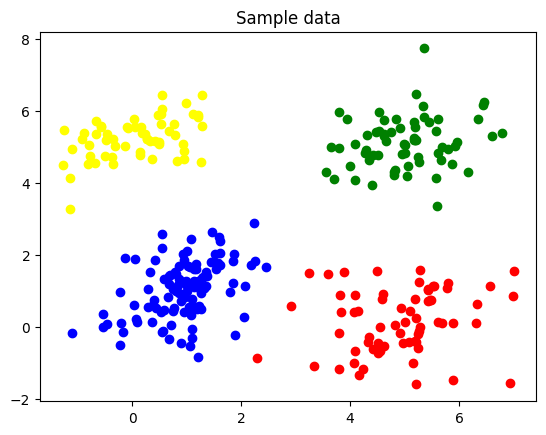

In [3]:
def generate_sample_data(n_samples, means, covariance, weights):
    """
    Generate n data points.
    """

    n_clusters, n_dim = means.shape

    data = np.zeros((n_samples, n_dim))
    labels = np.zeros((n_samples,))

    for i in range(n_samples):
        # pick up a cluster_id and generate data from that cluster
        k = np.random.choice(n_clusters, size=1, p=weights)[0]
        x = np.random.multivariate_normal(means[k], covariance[k])
        data[i] = x
        labels[i] = k

    return data, labels

# generate sample data
sample_means = np.array([
        [5,0],
        [1,1],
        [0,5],
        [5,5]
    ])

sample_covariance = np.array([
        [[0.7, 0.0], [0.0, 0.7]],
        [[0.5, 0.2], [0.2, 0.5]],
        [[0.6, 0.3], [0.3, 0.6]],
        [[0.5, 0.0], [0.0, 0.5]]
    ])

sample_weights = [1/5, 2/5, 1/5, 1/5]

# generate samples
n_clusters = 4
X, labels = generate_sample_data(300, sample_means, sample_covariance, sample_weights)

colors = ['red', 'blue', 'yellow', 'green']

for i in range(n_clusters):
    tmp_X = X[labels==i]
    plt.scatter(tmp_X[:, 0], tmp_X[:, 1], label=f'cluster_{str(i)}', color=colors[i])

plt.title('Sample data')
plt.show()

In [4]:
class MyGaussianMixtureModel:
    """
    Gaussian mixture model
    estimate parameters using Expectation Maximization

    Parameters
    ----------
    n_clusters: int
        The number of clusters (k)
        The data will be assigned to the most possible cluster

    n_steps: int
        The number of iterations to run the EM algorithm

    threshold: float
        The threshold if the difference between new likelihood and previous likelihood is smaller than this value,
        quit the calculatation

    seed: int
        random state to initialize the parameters
    """
    def __init__(self,
                 n_clusters: int,
                 n_steps: int,
                 threshold: float = 1e-5,
                 seed: int = 42):
        self.n_clusters = n_clusters
        self.n_steps = n_steps
        self.threshold = threshold
        self.seed = seed

        self.log_likelihood_list = []

        self.phi_list = []
        self.mean_list = []
        self.cov_list = []

        np.random.seed(self.seed)

    def initialize(self, X):
        # The data dimension
        n_sample, n_dim = X.shape

        # w
        self.w = np.zeros((n_sample, self.n_clusters))

        ## initialize parameters
        # phi
        # assign each cluster probability uniformly
        self.phi = np.full(self.n_clusters, 1/self.n_clusters)

        # mu
        # choose random initial points as mean value of each cluster
        initial_index = np.random.choice(n_sample, self.n_clusters)
        self.means = X[initial_index]

        # covariance
        # assign the whole data's covariance for the initial point
        self.cov = np.full((self.n_clusters, n_dim, n_dim), np.cov(X, rowvar=False))

        self.phi_list.append(self.phi)
        self.mean_list.append(self.means)
        self.cov_list.append(self.cov)

    def fit(self, X):

        fig = plt.figure()

        # The data dimension
        n_sample, n_dim = X.shape

        self.initialize(X)

        log_likelihood = 0

        for n_iter in range(self.n_steps):
            new_log_likelihood = self.e_step(X)

            self.m_step(X)

            if abs(new_log_likelihood - log_likelihood) < self.threshold:
                print('Converged')
                break

            log_likelihood = new_log_likelihood
            self.log_likelihood_list.append(log_likelihood)

        self.contour_plot()

    def e_step(self, X):
        """
        Expectation step (E-step)

        Parameters
        ----------
        X: np.array
            Given data

        Returns
        -------
        log_likelihood: np.array
            the likelihood calculated by the current parameters

        """

        for j in range(self.n_clusters):
            phi_j = self.phi[j]
            likelihood = multivariate_normal(self.means[j], self.cov[j]).pdf(X)

            self.w[:, j] = phi_j * likelihood

        log_likelihood = np.sum(np.log(np.sum(self.w, axis=1)))
        self.w = self.w / self.w.sum(axis=1, keepdims=1)

        return log_likelihood

    def m_step(self, X):
        """
        Maximization step (M-step)

        Parameters
        ----------
        X: np.array
            Given data

        Returns
        -------

        """

        # phi : (n_clusters,)
        phi = self.w.sum(axis=0)

        # update phi
        self.phi = phi / X.shape[0]

        # update mean
        self.means = np.dot(self.w.T, X) / phi.reshape(-1, 1)

        # update covariance
        for j in range(self.n_clusters):
            diff = (X - self.means[j]).T
            self.cov[j] = np.dot(self.w[:, j]*diff, diff.T) / phi[j]

        self.phi_list.append(self.phi)
        self.mean_list.append(self.means)
        self.cov_list.append(self.cov)

    def contour_plot(self):

        fig, ax = plt.subplots()
        camera = Camera(fig)

        colors = ['red', 'blue', 'yellow', 'green']

        x = np.arange(-2.0, 7.0, 0.01)
        y = np.arange(-2.0, 7.0, 0.01)
        x_grid, y_grid = np.meshgrid(x, y)
        coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T

        for i in range(len(self.phi_list)):
            ax.scatter(X[:,0], X[:,1], color='gray')

            means = self.mean_list[i]
            covs = self.cov_list[i]

            for j in range(self.n_clusters):
                mean = means[j]
                cov = covs[j]

                z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
                ax.contour(x_grid, y_grid, z_grid, colors=colors[j])

            camera.snap()

        animation = camera.animate()
        animation.save('output.mp4')

<Figure size 640x480 with 0 Axes>

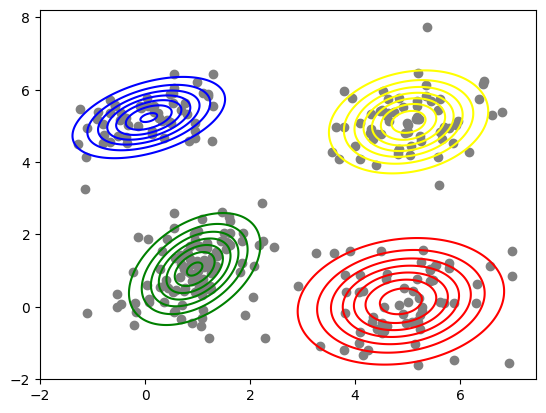

In [5]:
gmm = MyGaussianMixtureModel(n_clusters=4, n_steps=25)
gmm.fit(X)